In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.decomposition import PCA, FastICA,TruncatedSVD
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%time
sql_query ="SELECT \
      [Period] \
      ,IIF([Month]=1,1,0) Jan \
      ,IIF([Month]=2,1,0) Feb \
      ,IIF([Month]=3,1,0) Mar \
      ,IIF([Month]=4,1,0) Apr \
      ,IIF([Month]=5,1,0) May \
      ,IIF([Month]=6,1,0) Jun \
      ,IIF([Month]=7,1,0) Jul \
      ,IIF([Month]=8,1,0) Aug \
      ,IIF([Month]=9,1,0) Sep \
      ,IIF([Month]=10,1,0) Okt \
      ,IIF([Month]=11,1,0) Nov \
      ,IIF([Month]=12,1,0) Dec \
      ,DateDiff(DAY, a.[PurchaseDate], Period)/30.0 FromLastP \
      ,DateDiff(DAY, a.[FirstVisit], Period)/30.0 FromFirstP \
      ,IIF((DateDiff(DAY, Period, a.[NEXTDate])>=0 and DateDiff(DAY, Period, a.[NEXTDate])<=31),1,0) VisitInCurrentMonth \
      ,IIF(a.[NEXTDate]>Period, b.SMS * IIF((DateDiff(DAY, Period, a.[NEXTDate])>=0 and DateDiff(DAY, Period, a.[NEXTDate])<=31),1,0),0) PoSMS \
      ,IIF(a.[NEXTDate]>a.[PurchaseDate],1,0) BudetVisit \
      ,a.[PartnerID] \
      ,IIF(a.[Sex] = 'M',1,0) Sex \
      ,a.[CityID] \
      ,IIF(DATEDIFF(YEAR,a.[BirthDate],[Period])> 100 , 0 , DATEDIFF(YEAR,a.[BirthDate],[Period])) Age \
      ,[AVGFromLastPurchM]/30.0 [AVGFromLastPurchM] \
      ,[QNTVisits] \
      ,[SumSMS] \
      ,[SumQuantity] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
  FROM [Gold585].[dbo].[PurchaseGrid] a \
  left join Temp11 b on a.PartnerID = b.PartnerID and MONTH(a.NextDate) = MONTH(b.[PurchaseDate]) and YEAR(a.NextDate) = YEAR(b.[PurchaseDate]) \
  Where Period >= '20170101' \
  order by Period, a.[PurchaseDate]"

df = pd.read_sql(sql_query,conn)
df.head()

Wall time: 52min 6s


In [3]:
df.head()

,Period,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro
0,2017-01-01,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2017-01-01,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2017-01-01,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2017-01-01,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2017-01-01,1,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0


In [4]:
df.tail()

,Period,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro
56088885,2019-08-01,0,0,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56088886,2019-09-01,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56088887,2019-10-01,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56088888,2019-11-01,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56088889,2019-12-01,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.columns

Index(['Period', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Okt', 'Nov', 'Dec', 'FromLastP', 'FromFirstP', 'VisitInCurrentMonth',
       'PoSMS', 'BudetVisit', 'PartnerID', 'Sex', 'CityID', 'Age',
       'AVGFromLastPurchM', 'QNTVisits', 'SumSMS', 'SumQuantity', 'SumSumma',
       'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5', 'SUMM6',
       'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12', 'SUMP1k',
       'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco', 'SUMSERGI',
       'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56088890 entries, 0 to 56088889
Data columns (total 57 columns):
Period                 datetime64[ns]
Jan                    int64
Feb                    int64
Mar                    int64
Apr                    int64
May                    int64
Jun                    int64
Jul                    int64
Aug                    int64
Sep                    int64
Okt                    int64
Nov                    int64
Dec                    int64
FromLastP              float64
FromFirstP             float64
VisitInCurrentMonth    int64
PoSMS                  float64
BudetVisit             int64
PartnerID              float64
Sex                    int64
CityID                 float64
Age                    float64
AVGFromLastPurchM      float64
QNTVisits              float64
SumSMS                 float64
SumQuantity            float64
SumSumma               float64
AVGSumma               float64
SUMM1                  float64
SUMM2    

In [34]:
df[(df['Period']=='2018-09-01')&(df['PoSMS']==1)].shape

(8349, 57)

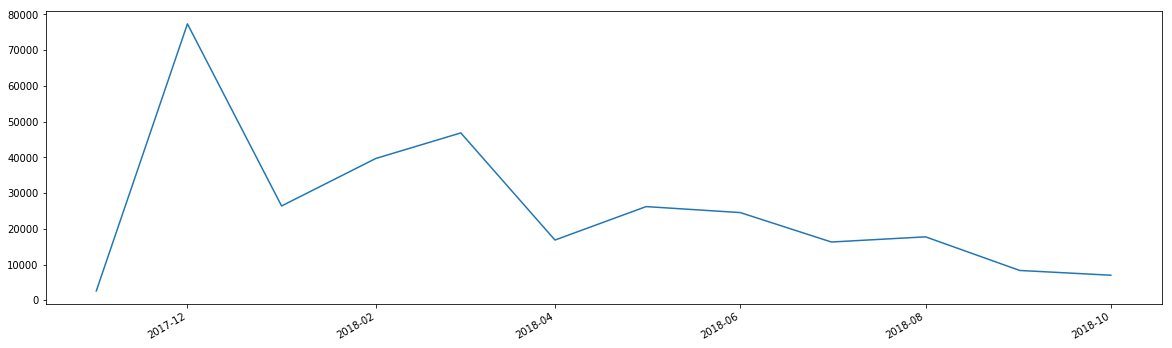

In [35]:
plt.figure(figsize=(20,6))
df[df['PoSMS']==1]['Period'].value_counts().plot()

In [163]:
#pred = df[df['Period']=='2018-11-01'].fillna(0).reset_index(drop=True)
#predId = pred['PartnerID']

In [8]:
#pred

In [36]:
#data = df[(df['Period']>='2017-01-01')].fillna(0).reset_index(drop=True)
df = df[(df['Period']<='2018-12-30')].fillna(0).reset_index(drop=True)
df.head()

,Period,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro
0,2017-01-01,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2017-01-01,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2017-01-01,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2017-01-01,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2017-01-01,1,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0


In [40]:
df.columns

Index(['Period', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       ...
       'CityID_119.0', 'CityID_120.0', 'CityID_121.0', 'CityID_122.0',
       'CityID_123.0', 'CityID_124.0', 'CityID_125.0', 'CityID_126.0',
       'CityID_127.0', 'CityID_128.0'],
      dtype='object', length=176)

In [42]:
df['PoSMS'].value_counts()

0.0    55778862
1.0      310016
Name: PoSMS, dtype: int64

In [39]:
%%time
df = pd.get_dummies(df, columns = ['CityID'],drop_first=True)

Wall time: 2min 16s


In [43]:
train = df[(df['Period']<='2018-08-30')].fillna(0).reset_index(drop=True)
test1 = df[(df['Period']=='2018-10-01')].fillna(0).reset_index(drop=True)
test2 = df[(df['Period']=='2018-09-01')].fillna(0).reset_index(drop=True)
pred  = df[(df['Period']=='2018-11-01')].fillna(0).reset_index(drop=True)
predId= pred['PartnerID']

In [45]:
train = df[(df['Period']>='2017-08-30')].fillna(0).reset_index(drop=True)

In [46]:
train['PoSMS'].value_counts()

0.0    41205029
1.0      310016
Name: PoSMS, dtype: int64

In [47]:
import random
ind = train[train['PoSMS']!=1].index.values.tolist()
ind_choise = random.sample(ind, 900000)
train = train[train.index.isin(ind_choise + train[train['PoSMS']==1].index.values.tolist())]

In [48]:
train[train['Period']=='2018-02-01']['PoSMS'].value_counts()

0.0    53424
1.0    39689
Name: PoSMS, dtype: int64

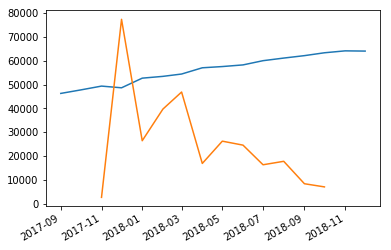

In [50]:
train[train['PoSMS']!=1]['Period'].value_counts().plot()
train[train['PoSMS']==1]['Period'].value_counts().plot()

In [51]:
pred.tail()

,Period,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,CityID_119.0,CityID_120.0,CityID_121.0,CityID_122.0,CityID_123.0,CityID_124.0,CityID_125.0,CityID_126.0,CityID_127.0,CityID_128.0
2934652,2018-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2934653,2018-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2934654,2018-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2934655,2018-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2934656,2018-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
train.columns.values

array(['Period', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Okt', 'Nov', 'Dec', 'FromLastP', 'FromFirstP',
       'VisitInCurrentMonth', 'PoSMS', 'BudetVisit', 'PartnerID', 'Sex',
       'Age', 'AVGFromLastPurchM', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4',
       'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11',
       'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k',
       'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'CityID_1.0', 'CityID_2.0',
       'CityID_3.0', 'CityID_4.0', 'CityID_5.0', 'CityID_6.0',
       'CityID_7.0', 'CityID_9.0', 'CityID_10.0', 'CityID_11.0',
       'CityID_12.0', 'CityID_13.0', 'CityID_14.0', 'CityID_15.0',
       'CityID_16.0', 'CityID_17.0', 'CityID_18.0', 'CityID_19.0',
       'CityID_20.0', 'CityID_21.0', 'CityID_2

In [52]:
y      = train['PoSMS']
yv     = train['VisitInCurrentMonth']
train  = train.drop(['Period', 'PoSMS','VisitInCurrentMonth','BudetVisit'],axis=1).reset_index(drop=True)
y1     = test1['PoSMS']
yv1    = test1['VisitInCurrentMonth']
test1  = test1.drop(['Period', 'PoSMS','VisitInCurrentMonth','BudetVisit'],axis=1).reset_index(drop=True)
y2     = test2['PoSMS']
yv2    = test2['VisitInCurrentMonth']
test2  = test2.drop(['Period', 'PoSMS','VisitInCurrentMonth','BudetVisit'],axis=1).reset_index(drop=True)
#y_p    = pred['PoSMS']#
#yv_p   = pred['VisitInCurrentMonth']
pred   = pred.drop(['Period', 'PoSMS','VisitInCurrentMonth','BudetVisit'],axis=1).reset_index(drop=True)
predId = pred['PartnerID']

In [55]:
train.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,...,CityID_119.0,CityID_120.0,CityID_121.0,CityID_122.0,CityID_123.0,CityID_124.0,CityID_125.0,CityID_126.0,CityID_127.0,CityID_128.0
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
col = train.columns.values

In [42]:
%%time
scaler = StandardScaler()
scaler.fit(train)

for_norm_tr = scaler.transform(train)
for_norm_t1 = scaler.transform(test1)
for_norm_t2 = scaler.transform(test2)
for_norm_p = scaler.transform(pred)

#all_data_s = scaler.transform(all_data)
train= pd.DataFrame(for_norm_tr,columns=train.columns)
test1= pd.DataFrame(for_norm_t1,columns=test1.columns)
test2= pd.DataFrame(for_norm_t2,columns=test2.columns)
pred= pd.DataFrame(for_norm_p,columns=pred.columns)
#all_data = pd.DataFrame(all_data_s,columns=all_data.columns)

Wall time: 2min 4s


In [57]:
train.columns.values

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Okt', 'Nov', 'Dec', 'FromLastP', 'FromFirstP', 'PartnerID', 'Sex',
       'Age', 'AVGFromLastPurchM', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4',
       'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11',
       'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k',
       'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'CityID_2.0', 'CityID_3.0',
       'CityID_4.0', 'CityID_5.0', 'CityID_6.0', 'CityID_7.0',
       'CityID_9.0', 'CityID_10.0', 'CityID_11.0', 'CityID_12.0',
       'CityID_13.0', 'CityID_14.0', 'CityID_15.0', 'CityID_16.0',
       'CityID_17.0', 'CityID_18.0', 'CityID_19.0', 'CityID_20.0',
       'CityID_21.0', 'CityID_22.0', 'CityID_23.0', 'CityID_24.0',
       'CityID_25.0', 'CityID_26.0', 'Cit

In [58]:
#X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state=42,stratify=y,shuffle =True)
X_train, X_test, y_train, y_test = train, test1,y,y1

In [91]:
X_train[X_train['Sep']==1].head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,...,CityID_119.0,CityID_120.0,CityID_121.0,CityID_122.0,CityID_123.0,CityID_124.0,CityID_125.0,CityID_126.0,CityID_127.0,CityID_128.0
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='entropy', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [100],
   # 'class_weight':['balanced'],
   # 'max_depth' : [None,2,5,10,15]
   #  'criterion':['entropy','gini']
   # 'max_depth' : [2,5,10],
   # 'max_features': ['auto', 'sqrt', 'log2','None']
}
model = GridSearchCV(estimator=ExTC, param_grid=param_grid, cv= 5)
model.fit(X_train, y_train)
#ExTC.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
#predicted = ExTC.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00   2892691
        1.0       0.41      1.00      0.58      7019

avg / total       1.00      1.00      1.00   2899710

[[2882417   10274]
 [      0    7019]]
0.9982241449224961
Wall time: 7min 51s


In [87]:
model.score(X_train)

ValueError: Expected array-like (array or non-string sequence), got None

In [60]:
pred2 = model.predict_proba(test2)[:,1]

In [61]:
print(metrics.classification_report(y2, pred2>0.5))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00   2849752
        1.0       0.38      1.00      0.55      8349

avg / total       1.00      1.00      1.00   2858101



In [63]:
pred2>0.5

array([False, False, False, ...,  True,  True,  True])

In [64]:
print(roc_auc_score(y2, pred2>0.5))

0.9975908429926533


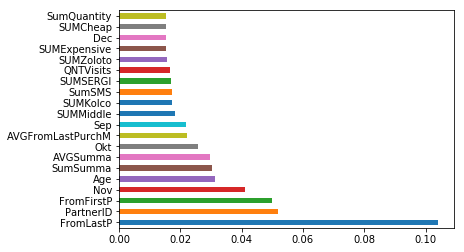

In [62]:
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [63]:
predNov =  model.predict_proba(pred)[:,1]

In [65]:
pd.concat([predId,pd.Series(predNov)],axis=1).to_csv('PredIDNov2.csv')

In [71]:
(predNov>0.4).to_list().value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'to_list'

In [73]:
predNovClass =  model.predict(pred)

In [83]:
pd.DataFrame(predNov>0.15)[0].value_counts()

False    2924384
True       10273
Name: 0, dtype: int64

In [157]:
from catboost import CatBoostClassifier
from catboost import Pool

#cat_features = []
train_data = X_train
train_labels = y_train
test_data = X_test

p = Pool(X_train, y_train ) #,cat_features=cat_features)

model = CatBoostClassifier(iterations=1000, learning_rate=0.5, depth=7, loss_function='Logloss',silent=False)

model.fit(p)
# Прогноз класса
preds_class = model.predict(test_data)
# Прогноз вероятности каждого класса
preds_proba = model.predict_proba(test_data)

# Проверка модели
print(metrics.classification_report(y_test, preds_class))
print(metrics.confusion_matrix(y_test, preds_class))
print(roc_auc_score(y_test, preds_class))

0:	learn: 0.5293423	total: 743ms	remaining: 12m 22s
1:	learn: 0.5011332	total: 1.36s	remaining: 11m 20s
2:	learn: 0.4903167	total: 1.95s	remaining: 10m 48s
3:	learn: 0.4857991	total: 2.56s	remaining: 10m 37s
4:	learn: 0.4826007	total: 3.14s	remaining: 10m 25s
5:	learn: 0.4805361	total: 3.69s	remaining: 10m 11s
6:	learn: 0.4788324	total: 4.23s	remaining: 10m
7:	learn: 0.4778172	total: 4.82s	remaining: 9m 57s
8:	learn: 0.4769421	total: 5.41s	remaining: 9m 55s
9:	learn: 0.4763238	total: 5.94s	remaining: 9m 47s
10:	learn: 0.4757869	total: 6.48s	remaining: 9m 42s
11:	learn: 0.4750355	total: 7.06s	remaining: 9m 41s
12:	learn: 0.4745425	total: 7.6s	remaining: 9m 37s
13:	learn: 0.4741861	total: 8.14s	remaining: 9m 33s
14:	learn: 0.4737173	total: 8.73s	remaining: 9m 33s
15:	learn: 0.4733495	total: 9.26s	remaining: 9m 29s
16:	learn: 0.4730792	total: 9.82s	remaining: 9m 27s
17:	learn: 0.4728313	total: 10.4s	remaining: 9m 25s
18:	learn: 0.4725316	total: 10.9s	remaining: 9m 23s
19:	learn: 0.4721652

158:	learn: 0.4522219	total: 1m 26s	remaining: 7m 37s
159:	learn: 0.4521212	total: 1m 26s	remaining: 7m 36s
160:	learn: 0.4520316	total: 1m 27s	remaining: 7m 36s
161:	learn: 0.4519499	total: 1m 28s	remaining: 7m 35s
162:	learn: 0.4518237	total: 1m 28s	remaining: 7m 34s
163:	learn: 0.4517508	total: 1m 29s	remaining: 7m 34s
164:	learn: 0.4516826	total: 1m 29s	remaining: 7m 33s
165:	learn: 0.4516325	total: 1m 30s	remaining: 7m 32s
166:	learn: 0.4515622	total: 1m 30s	remaining: 7m 32s
167:	learn: 0.4514698	total: 1m 31s	remaining: 7m 31s
168:	learn: 0.4513274	total: 1m 31s	remaining: 7m 30s
169:	learn: 0.4512502	total: 1m 32s	remaining: 7m 29s
170:	learn: 0.4511248	total: 1m 32s	remaining: 7m 29s
171:	learn: 0.4510021	total: 1m 33s	remaining: 7m 28s
172:	learn: 0.4509533	total: 1m 33s	remaining: 7m 27s
173:	learn: 0.4508611	total: 1m 34s	remaining: 7m 27s
174:	learn: 0.4507674	total: 1m 34s	remaining: 7m 26s
175:	learn: 0.4506787	total: 1m 35s	remaining: 7m 26s
176:	learn: 0.4506262	total:

311:	learn: 0.4386996	total: 2m 47s	remaining: 6m 8s
312:	learn: 0.4386028	total: 2m 47s	remaining: 6m 7s
313:	learn: 0.4384961	total: 2m 48s	remaining: 6m 7s
314:	learn: 0.4383886	total: 2m 48s	remaining: 6m 6s
315:	learn: 0.4383045	total: 2m 49s	remaining: 6m 6s
316:	learn: 0.4381879	total: 2m 49s	remaining: 6m 5s
317:	learn: 0.4380968	total: 2m 50s	remaining: 6m 5s
318:	learn: 0.4380144	total: 2m 50s	remaining: 6m 4s
319:	learn: 0.4379350	total: 2m 51s	remaining: 6m 4s
320:	learn: 0.4378371	total: 2m 51s	remaining: 6m 3s
321:	learn: 0.4377460	total: 2m 52s	remaining: 6m 3s
322:	learn: 0.4376750	total: 2m 52s	remaining: 6m 2s
323:	learn: 0.4376112	total: 2m 53s	remaining: 6m 1s
324:	learn: 0.4375210	total: 2m 53s	remaining: 6m 1s
325:	learn: 0.4374223	total: 2m 54s	remaining: 6m
326:	learn: 0.4373317	total: 2m 55s	remaining: 6m
327:	learn: 0.4372288	total: 2m 55s	remaining: 5m 59s
328:	learn: 0.4371076	total: 2m 56s	remaining: 5m 59s
329:	learn: 0.4369846	total: 2m 56s	remaining: 5m 

465:	learn: 0.4257453	total: 4m 8s	remaining: 4m 45s
466:	learn: 0.4256620	total: 4m 9s	remaining: 4m 44s
467:	learn: 0.4255613	total: 4m 9s	remaining: 4m 44s
468:	learn: 0.4254778	total: 4m 10s	remaining: 4m 43s
469:	learn: 0.4254207	total: 4m 11s	remaining: 4m 43s
470:	learn: 0.4253262	total: 4m 11s	remaining: 4m 42s
471:	learn: 0.4252449	total: 4m 12s	remaining: 4m 42s
472:	learn: 0.4251332	total: 4m 12s	remaining: 4m 41s
473:	learn: 0.4250333	total: 4m 13s	remaining: 4m 40s
474:	learn: 0.4249672	total: 4m 13s	remaining: 4m 40s
475:	learn: 0.4248701	total: 4m 14s	remaining: 4m 39s
476:	learn: 0.4247721	total: 4m 14s	remaining: 4m 39s
477:	learn: 0.4246722	total: 4m 15s	remaining: 4m 38s
478:	learn: 0.4246057	total: 4m 15s	remaining: 4m 38s
479:	learn: 0.4245552	total: 4m 16s	remaining: 4m 37s
480:	learn: 0.4244545	total: 4m 16s	remaining: 4m 37s
481:	learn: 0.4243841	total: 4m 17s	remaining: 4m 36s
482:	learn: 0.4243029	total: 4m 17s	remaining: 4m 36s
483:	learn: 0.4242140	total: 4m

618:	learn: 0.4139984	total: 5m 29s	remaining: 3m 22s
619:	learn: 0.4139104	total: 5m 30s	remaining: 3m 22s
620:	learn: 0.4138116	total: 5m 30s	remaining: 3m 21s
621:	learn: 0.4137307	total: 5m 31s	remaining: 3m 21s
622:	learn: 0.4136921	total: 5m 31s	remaining: 3m 20s
623:	learn: 0.4135946	total: 5m 32s	remaining: 3m 20s
624:	learn: 0.4134955	total: 5m 32s	remaining: 3m 19s
625:	learn: 0.4133986	total: 5m 33s	remaining: 3m 19s
626:	learn: 0.4133153	total: 5m 33s	remaining: 3m 18s
627:	learn: 0.4132270	total: 5m 34s	remaining: 3m 18s
628:	learn: 0.4131397	total: 5m 34s	remaining: 3m 17s
629:	learn: 0.4130583	total: 5m 35s	remaining: 3m 16s
630:	learn: 0.4129914	total: 5m 35s	remaining: 3m 16s
631:	learn: 0.4129263	total: 5m 36s	remaining: 3m 15s
632:	learn: 0.4128329	total: 5m 36s	remaining: 3m 15s
633:	learn: 0.4127482	total: 5m 37s	remaining: 3m 14s
634:	learn: 0.4126404	total: 5m 37s	remaining: 3m 14s
635:	learn: 0.4125625	total: 5m 38s	remaining: 3m 13s
636:	learn: 0.4124757	total:

771:	learn: 0.4031515	total: 6m 50s	remaining: 2m 1s
772:	learn: 0.4031077	total: 6m 51s	remaining: 2m
773:	learn: 0.4030246	total: 6m 51s	remaining: 2m
774:	learn: 0.4029697	total: 6m 52s	remaining: 1m 59s
775:	learn: 0.4029310	total: 6m 52s	remaining: 1m 59s
776:	learn: 0.4028948	total: 6m 53s	remaining: 1m 58s
777:	learn: 0.4028188	total: 6m 53s	remaining: 1m 58s
778:	learn: 0.4027431	total: 6m 54s	remaining: 1m 57s
779:	learn: 0.4027092	total: 6m 54s	remaining: 1m 57s
780:	learn: 0.4026655	total: 6m 55s	remaining: 1m 56s
781:	learn: 0.4025900	total: 6m 56s	remaining: 1m 55s
782:	learn: 0.4025428	total: 6m 56s	remaining: 1m 55s
783:	learn: 0.4024641	total: 6m 57s	remaining: 1m 54s
784:	learn: 0.4023837	total: 6m 57s	remaining: 1m 54s
785:	learn: 0.4022884	total: 6m 58s	remaining: 1m 53s
786:	learn: 0.4022338	total: 6m 58s	remaining: 1m 53s
787:	learn: 0.4021633	total: 6m 59s	remaining: 1m 52s
788:	learn: 0.4021159	total: 6m 59s	remaining: 1m 52s
789:	learn: 0.4020409	total: 7m	remai

926:	learn: 0.3928445	total: 8m 12s	remaining: 38.8s
927:	learn: 0.3927278	total: 8m 13s	remaining: 38.3s
928:	learn: 0.3926690	total: 8m 13s	remaining: 37.7s
929:	learn: 0.3925972	total: 8m 14s	remaining: 37.2s
930:	learn: 0.3925324	total: 8m 14s	remaining: 36.7s
931:	learn: 0.3924505	total: 8m 15s	remaining: 36.1s
932:	learn: 0.3923754	total: 8m 15s	remaining: 35.6s
933:	learn: 0.3923522	total: 8m 16s	remaining: 35.1s
934:	learn: 0.3922835	total: 8m 16s	remaining: 34.5s
935:	learn: 0.3922345	total: 8m 17s	remaining: 34s
936:	learn: 0.3921656	total: 8m 18s	remaining: 33.5s
937:	learn: 0.3920796	total: 8m 18s	remaining: 33s
938:	learn: 0.3919984	total: 8m 19s	remaining: 32.4s
939:	learn: 0.3919206	total: 8m 19s	remaining: 31.9s
940:	learn: 0.3918163	total: 8m 20s	remaining: 31.4s
941:	learn: 0.3917492	total: 8m 20s	remaining: 30.8s
942:	learn: 0.3916794	total: 8m 21s	remaining: 30.3s
943:	learn: 0.3916171	total: 8m 21s	remaining: 29.8s
944:	learn: 0.3915311	total: 8m 22s	remaining: 29.

In [158]:
print(roc_auc_score(y2, model.predict(test2)))

0.690599396421


In [162]:
pred

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,...,CityID_119.0,CityID_120.0,CityID_121.0,CityID_122.0,CityID_123.0,CityID_124.0,CityID_125.0,CityID_126.0,CityID_127.0,CityID_128.0
0,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717
1,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717
2,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717
3,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717
4,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717
5,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717
6,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717
7,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717
8,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717
9,-0.396274,-0.448702,-0.47647,-0.368787,0.0,0.0,0.0,0.0,0.0,-0.271249,...,-0.020955,-0.070032,-0.109767,-0.142348,-0.101342,-0.081337,-0.015045,-0.021118,-0.024943,-0.086717


In [160]:
predict = model.predict(pred)
predictedID_PoSMS = pd.concat([predId,pd.DataFrame(predict,columns=['PoSMS'])],axis=1,ignore_index=False)

In [161]:
predictedID_PoSMS['PoSMS'].value_counts()

0.0    32976
1.0      663
Name: PoSMS, dtype: int64

In [ ]:
predictedID_metall.to_csv('poSMS_pred.csv')

In [33]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.25, random_state=42,stratify=y_s,shuffle =True)

In [187]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [100],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
   # 'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC, param_grid=param_grid, cv= 5)
model.fit(X_train_s, y_train_s)
#ExTC.fit(X_train_s, y_train_s)
#print(model)
# make predictions
expected = y_test_s
predicted = model.predict(X_test_s)
#predicted = ExTC.predict(X_test_s)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.68      0.76      0.72    172267
          1       0.72      0.64      0.68    167291

avg / total       0.70      0.70      0.70    339558

[[130205  42062]
 [ 60064 107227]]
0.6983967380234427
Wall time: 13min 44s


In [94]:
model.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [48]:
predict = ExTC.predict(pred)

In [49]:
predictedID_metall = pd.concat([predId,pd.DataFrame(predict,columns=['Zoloto'])],axis=1,ignore_index=False)

In [50]:
predictedID_metall.head()

,PartnerID,Zoloto
0,10,0
1,100,1
2,1000,1
3,1000037,1
4,1000038,1


In [51]:
predictedID_metall['Zoloto'].value_counts()

1    1644809
0    1004141
Name: Zoloto, dtype: int64

In [285]:
predictedID_metall.to_csv('metal_pred.csv')